In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [3]:
import ast
import os

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import cm

from ficus import FigureManager
from IPython.display import FileLink

import yaml

In [4]:
with open('config.yaml') as fp:
    info = yaml.load(fp)

In [ ]:
def get_cdbg_stats_data(filename):
    data = pd.read_csv(filename)
    data['t'] = data['read_n'] / data['read_n'].max()

    cdbg_cols =['n_full', 'n_tips', 'n_islands', 'n_trivial', 'n_circular']
    for col in cdbg_cols:
        data[col + '_p'] = data[col] / data['n_unodes']
    data['dnode_p'] = data['n_dnodes'] / (data['n_unodes'] + data['n_dnodes'])
    data['kmer_p'] = data['n_unique'] / data['n_unique'].max()
    prop_cols = [col + '_p' for col in cdbg_cols] + [ 'kmer_p']
    
    return data, prop_cols

In [5]:
import glob
import re
from collections import OrderedDict

In [6]:
hu_dirs = glob.glob('outputs/Hu_metagenome/hu-genome*/')
id_pattern = re.compile(r'\D*?(\d\d)\/')
hu_samples = OrderedDict({int(id_pattern.match(hu_dir).group(1)): hu_dir for hu_dir in hu_dirs})
hu_samples = OrderedDict(sorted(hu_samples.items(), key = lambda x: x[0]))

In [44]:
def plot_frag_proportional(stats_filename, ax=None, legend=False):
    data = pd.read_csv(stats_filename, index_col=False).reset_index(drop=True)
    cols = list(set(data.columns) - {'read_n'})
    prop_cols = [col+'_p' for col in cols]
    for col, prop_col in zip(cols, prop_cols):
        data[prop_col] = data[col] / data[cols].sum(axis=1)
    data['t'] = data['read_n'] / data['read_n'].max()
    
    def _plot(ax):
        _cols = prop_cols + ['t']
        data[_cols].plot(x='t', lw=2, ax=ax, legend=legend)
        if legend:
            ax.legend()
    
    if ax is not None:
        _plot(ax)
    else:
        with FigureManager(filename=stats_filename + '.proportional.png',
                           figsize=(12,8),
                           show=True) as (fig, ax):
            _plot(ax)

    return data, (ax.get_figure(), ax)

In [55]:
def plot_frag_absolute(stats_filename, ax=None, legend=False):
    data = pd.read_csv(stats_filename, index_col=False).reset_index(drop=True)
    data['t'] = data['read_n'] / data['read_n'].max()
    cols = list(set(data.columns) - {'read_n'})
    
    def _plot(ax):
        data[cols].plot(x='t', lw=2, ax=ax, legend=legend)
        if legend:
            ax.legend()
    
    if ax is not None:
        _plot(ax)
    else:
        with FigureManager(filename=stats_filename + '.absolute.png',
                           figsize=(12,8),
                           show=True) as (fig, ax):
            _plot(ax)

    return data, (ax.get_figure(), ax)

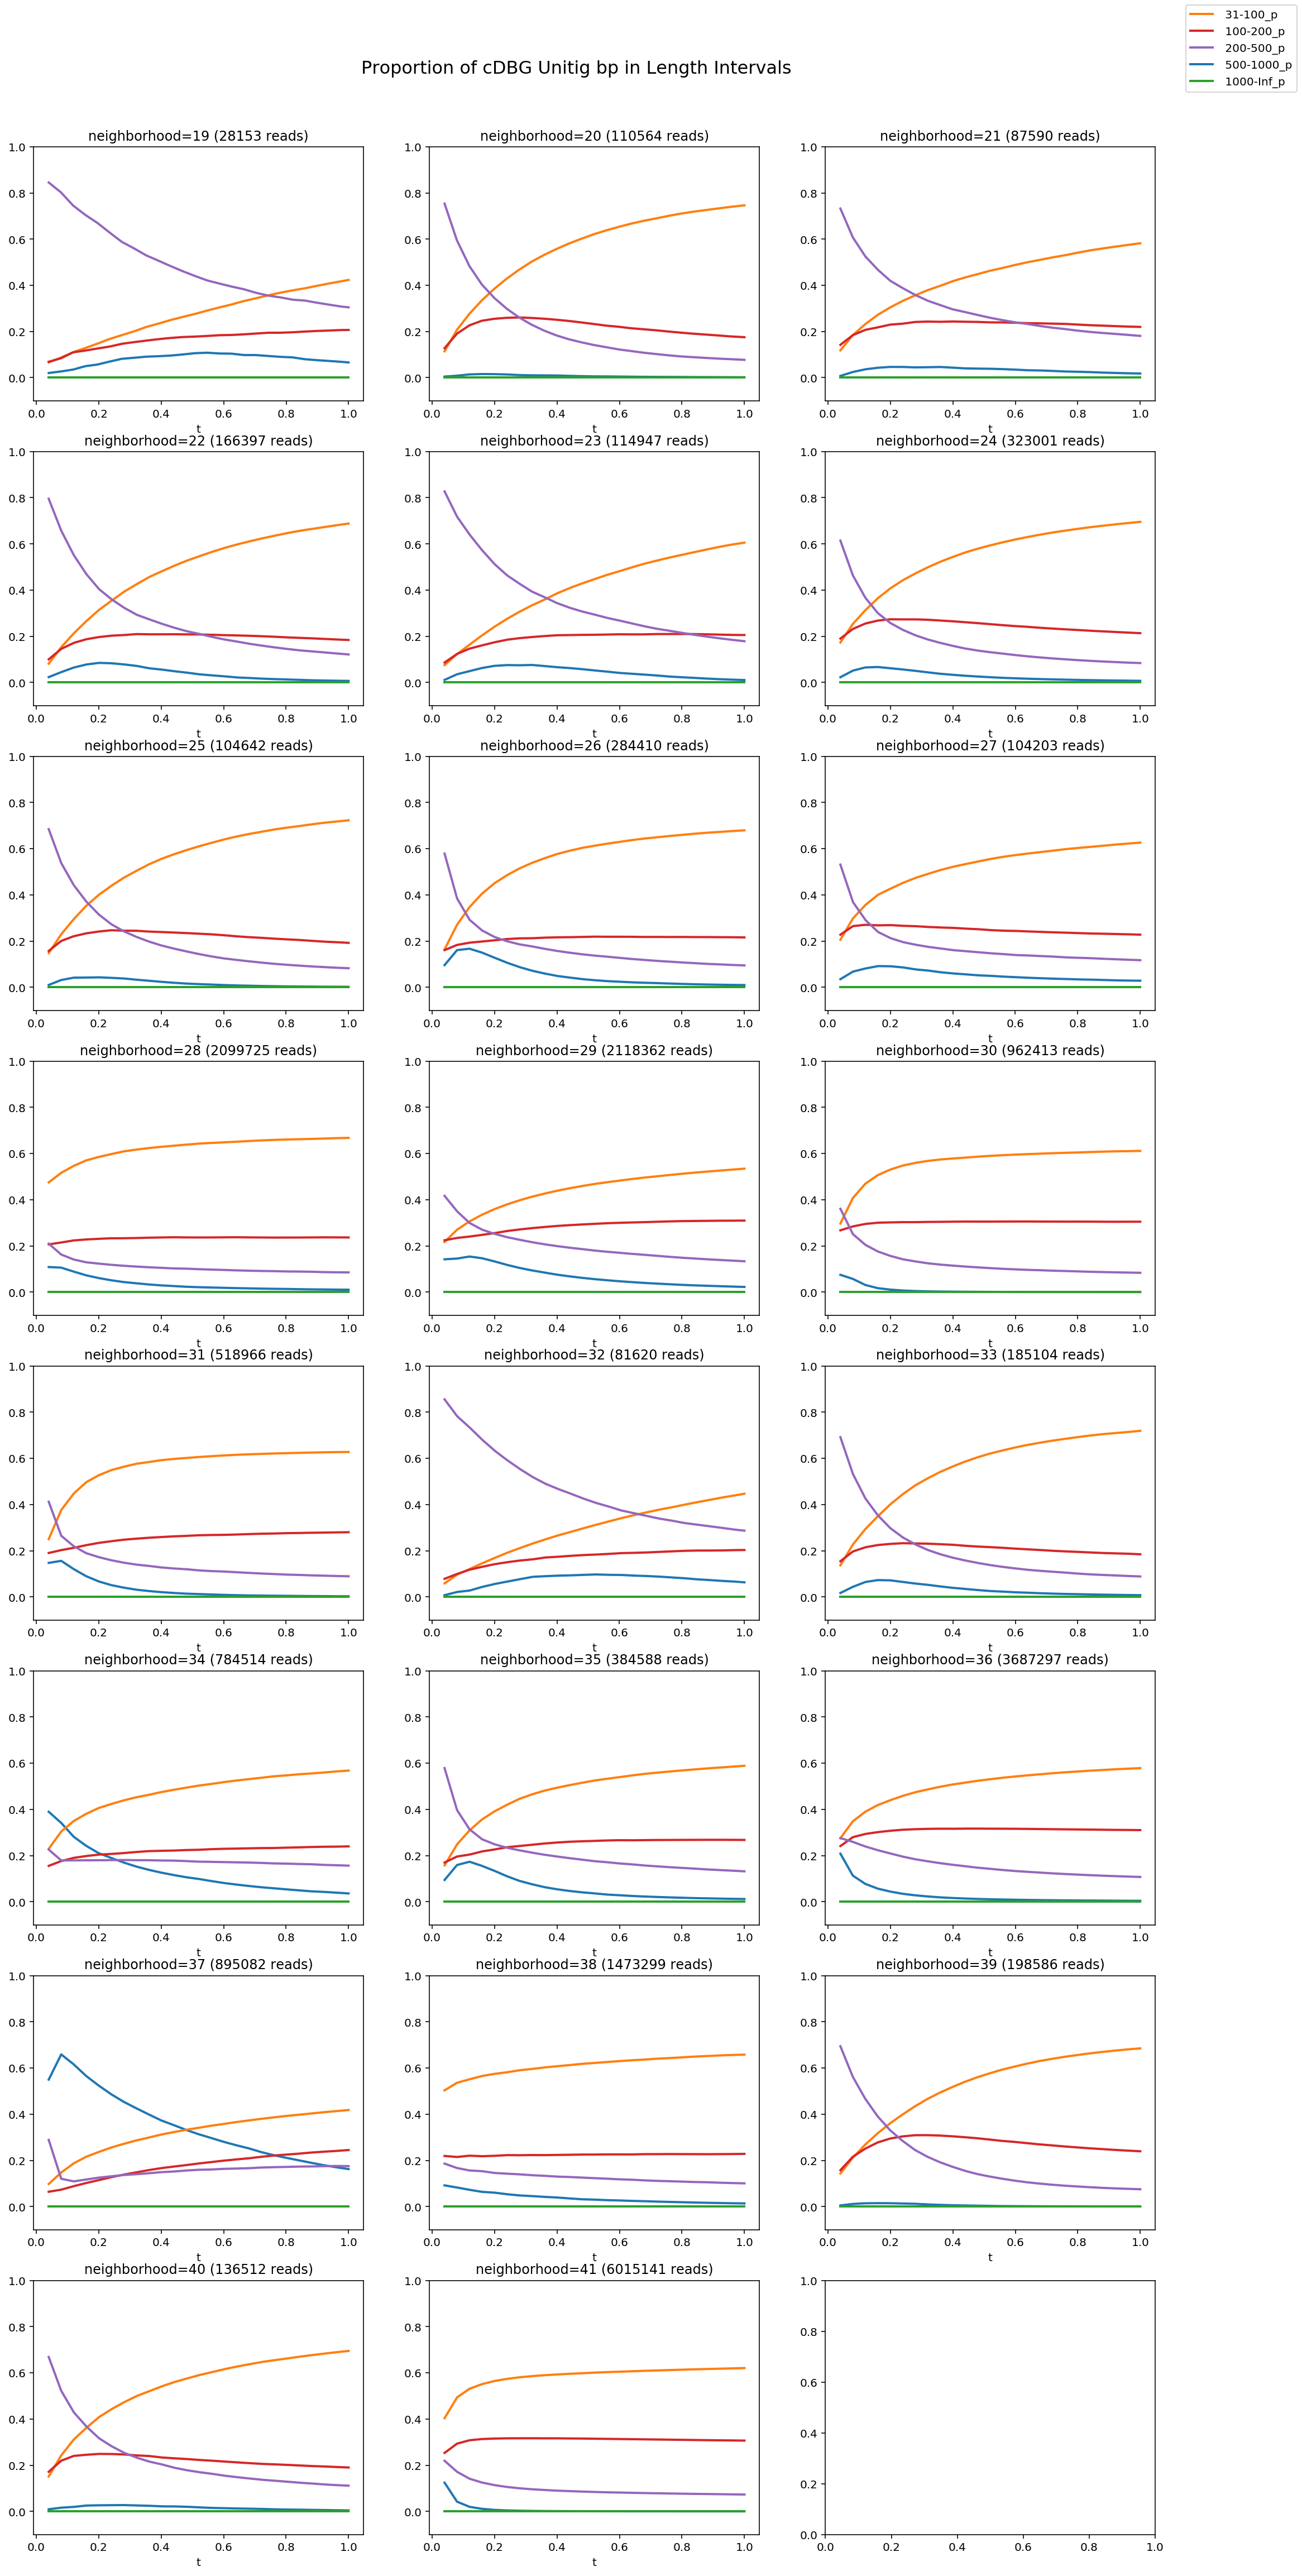

In [60]:
ncols, nrows = 3, 8
with FigureManager(figsize=(18,36), show=True, nrows=nrows, ncols=ncols) as (fig, ax):
    for i, (neighborhood, hu_dir) in enumerate(hu_samples.items()):
        row        = i // ncols
        col        = i % ncols
        stats_file = os.path.join(hu_dir, 'boink.cdbg.unitigs.bp.csv')

        try:
            data, _ = plot_frag_proportional(stats_file, ax=ax[row][col])
        except FileNotFoundError:
            print('Compute not finished yet.')
            ax[row][col].set_visible(False)
            continue
    
        title = 'neighborhood={0} ({1} reads)'.format(neighborhood, data['read_n'].max())
        ax[row][col].set_title(title)
        ax[row][col].set_ylim(-0.1, 1.0)
        
    handles, labels = ax[row][col].get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0].split('-')[0])))

    fig.legend(handles, labels, loc='upper right')
    fig.suptitle('Proportion of cDBG Unitig bp in Length Intervals', fontsize=16)
    fig.subplots_adjust(top=0.95)

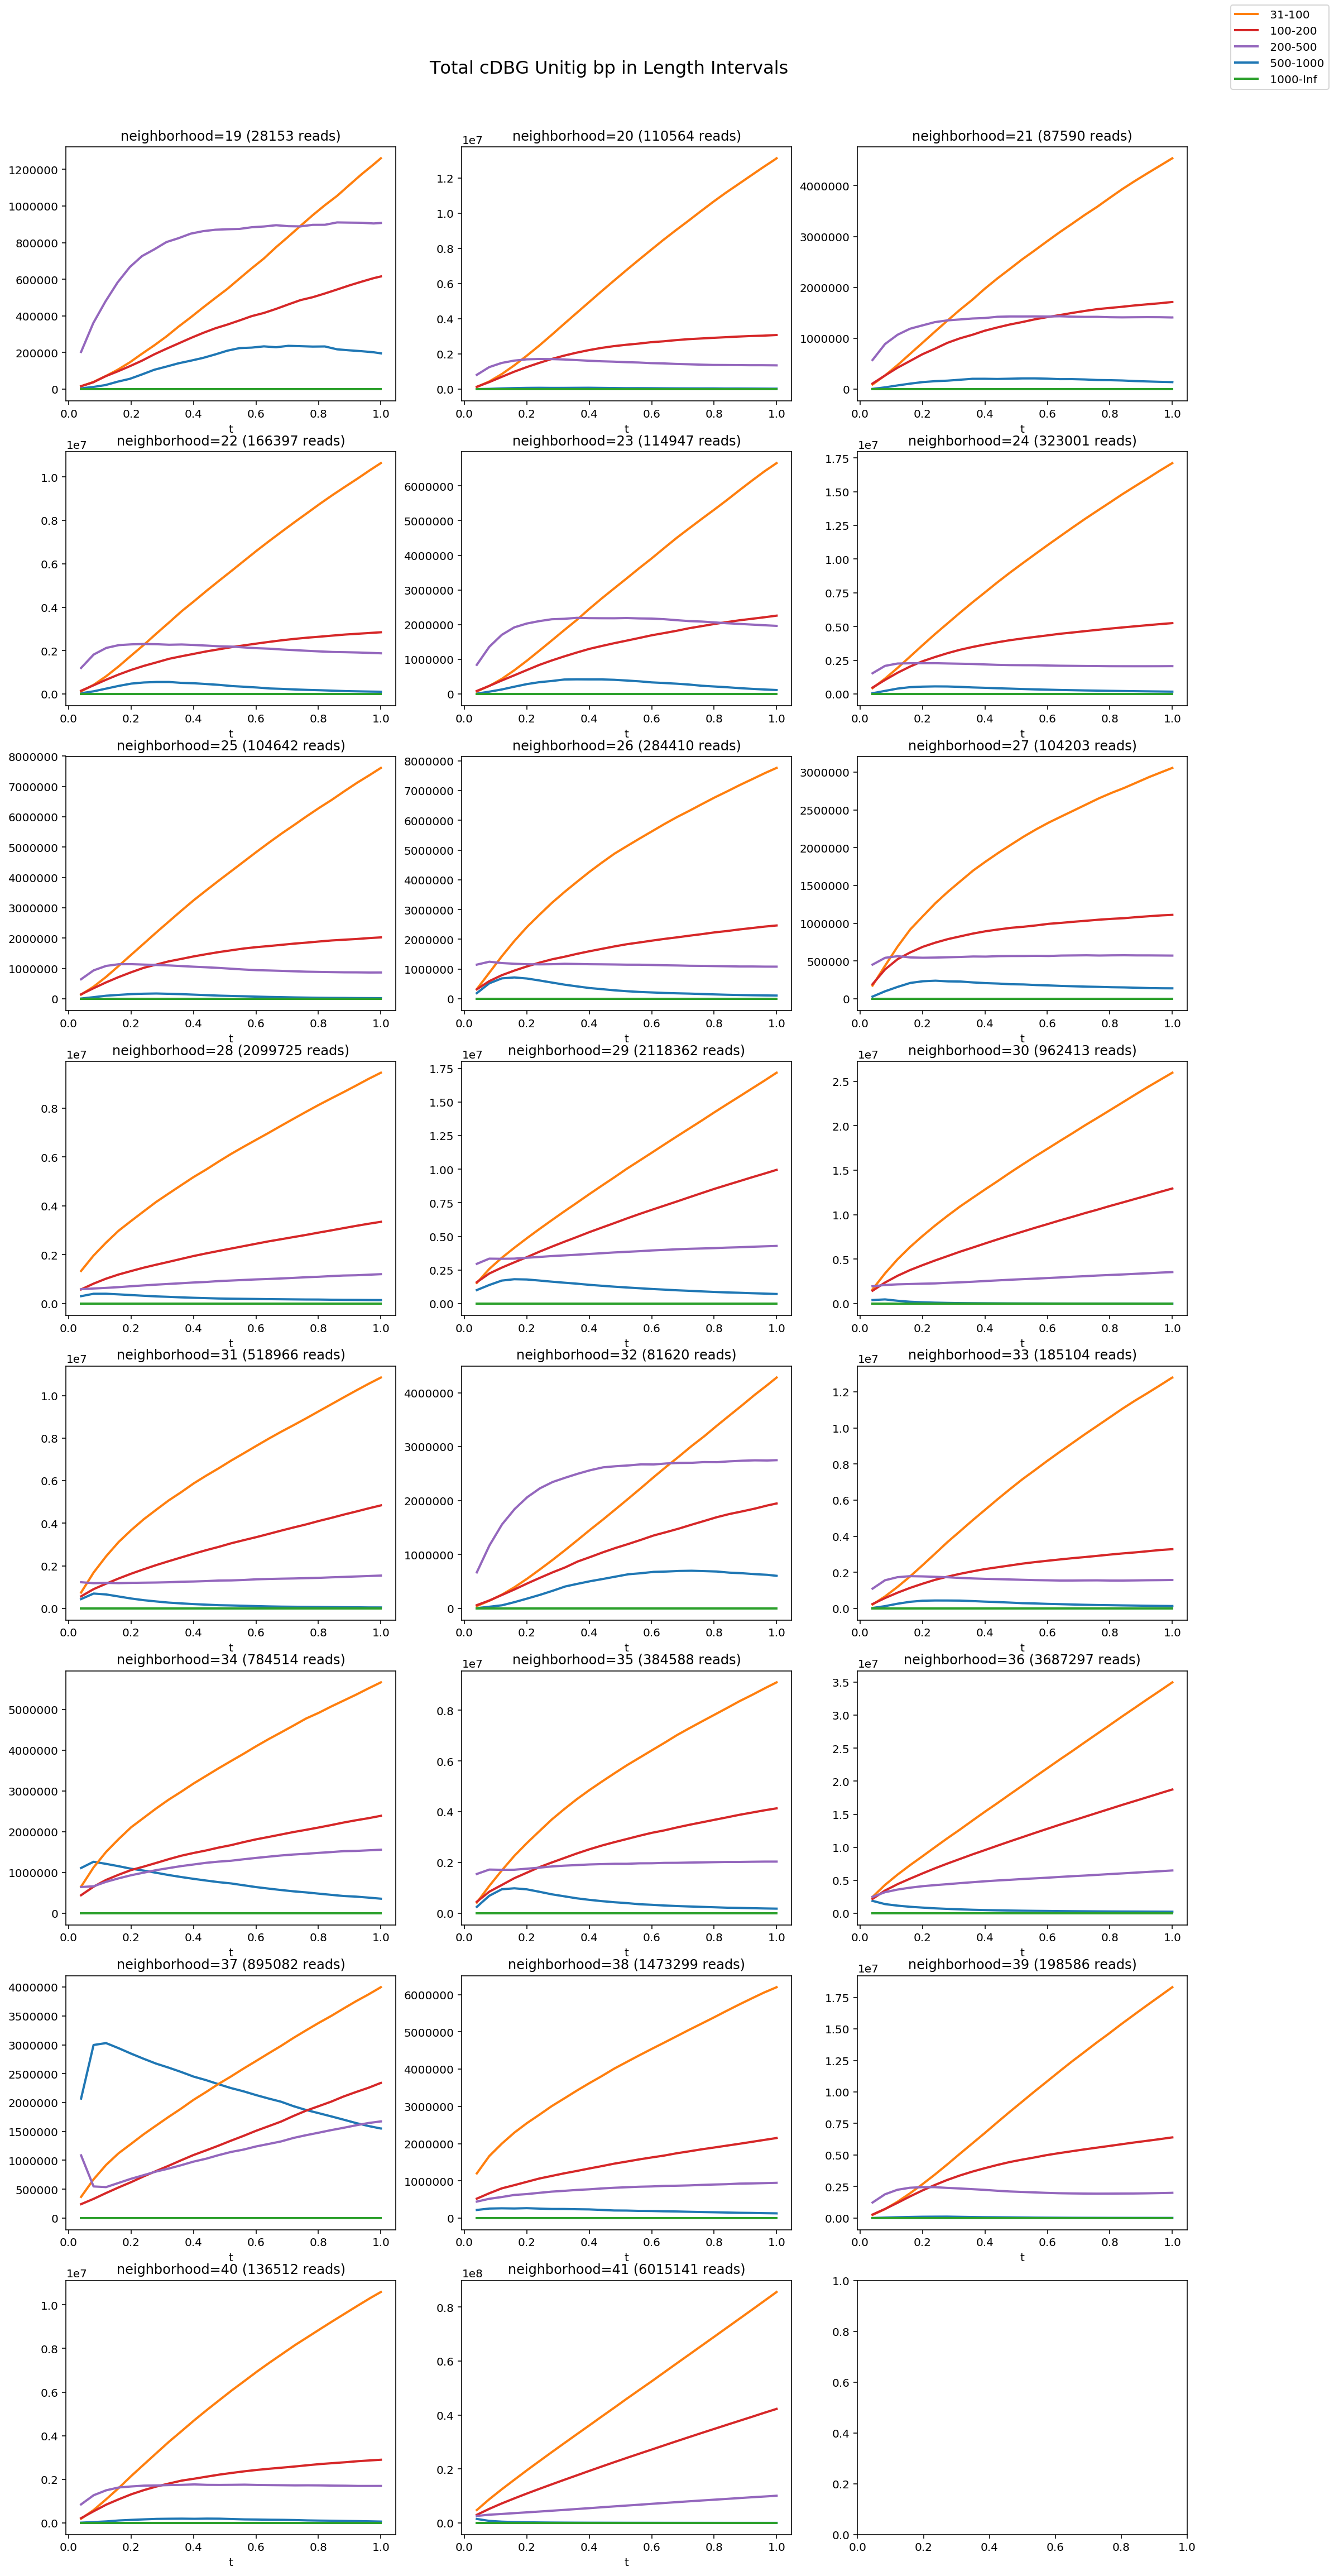

In [61]:
ncols, nrows = 3, 8
with FigureManager(figsize=(18,36), show=True, nrows=nrows, ncols=ncols) as (fig, ax):
    for i, (neighborhood, hu_dir) in enumerate(hu_samples.items()):
        row        = i // ncols
        col        = i % ncols
        stats_file = os.path.join(hu_dir, 'boink.cdbg.unitigs.bp.csv')

        try:
            data, _ = plot_frag_absolute(stats_file, ax=ax[row][col])
        except FileNotFoundError:
            print('Compute not finished yet.')
            ax[row][col].set_visible(False)
            continue
    
        title = 'neighborhood={0} ({1} reads)'.format(neighborhood, data['read_n'].max())
        ax[row][col].set_title(title)
        
    handles, labels = ax[row][col].get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0].split('-')[0])))
    fig.legend(handles, labels, loc='upper right')
    fig.suptitle('Total cDBG Unitig bp in Length Intervals', fontsize=16)
    fig.subplots_adjust(top=0.95)